# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on 1 Million Cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1M brain cells with Unified Virtual Memory to oversubscribe GPU memory. See the README for instructions to download this dataset.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import sys
import time
import os

import cudf
import cupy as cp

from cuml.manifold import TSNE
from cuml.cluster import KMeans

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')

In [2]:
import cuml
cuml.__version__

'0.14.0+0.g31202da.dirty'

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory

In [3]:
import rmm

rmm.reinitialize(managed_memory=True)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [4]:
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

In [5]:
USE_FIRST_N_CELLS = 1000000

## Set parameters

In [6]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Tbr1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute
pca_train_ratio = 0.35 # percentage of cells to use for PCA training
n_pca_batches = 10

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 25 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Louvain
louvain_resolution = 0.4

In [7]:
start = time.time()

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [8]:
data_load_start = time.time()

In [9]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 1min 11s, sys: 8.21 s, total: 1min 20s
Wall time: 1min 19s


In [10]:
adata.shape

(1306127, 27998)

For this example, we select the first 1 million cells in the dataset. We maintain the index of unique cells and genes in our dataset:

In [11]:
%%time
cells = cudf.Series(adata.obs_names)[:USE_FIRST_N_CELLS]
genes = cudf.Series(adata.var_names)

CPU times: user 596 ms, sys: 288 ms, total: 884 ms
Wall time: 884 ms


In [12]:
%%time
sparse_gpu_array = cp.sparse.csr_matrix(adata.X, dtype=cp.float32)
sparse_gpu_array = sparse_gpu_array[:USE_FIRST_N_CELLS]

CPU times: user 5.79 s, sys: 8.92 s, total: 14.7 s
Wall time: 14.7 s


Verify the shape of the resulting sparse matrix:

In [13]:
sparse_gpu_array.shape

(1000000, 27998)

And the number of non-zero values in the matrix:

In [14]:
sparse_gpu_array.nnz

2036870686

In [15]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 95.53542470932007


## Preprocessing

In [16]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [17]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, 
                                                    min_genes=min_genes_per_cell, 
                                                    max_genes=max_genes_per_cell)

CPU times: user 7.3 s, sys: 9.97 s, total: 17.3 s
Wall time: 17.4 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [18]:
%%time
sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes, min_cells=1)

CPU times: user 13.8 s, sys: 9.82 s, total: 23.7 s
Wall time: 23.7 s


The size of our count matrix is now reduced.

In [19]:
sparse_gpu_array.shape

(989838, 23781)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [20]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.normalize_total(sparse_gpu_array, target_sum=1e4)

CPU times: user 809 µs, sys: 299 µs, total: 1.11 ms
Wall time: 1.32 ms


Next, we log transform the count matrix.

In [21]:
%%time
sparse_gpu_array = sparse_gpu_array.log1p()

CPU times: user 1.41 s, sys: 629 ms, total: 2.04 s
Wall time: 2.05 s


### Select Most Variable Genes

We convert the count matrix to an annData object.

In [22]:
%%time
adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes.to_pandas()

CPU times: user 3.59 s, sys: 3.32 s, total: 6.91 s
Wall time: 6.91 s


Using scanpy, we filter the count matrix to retain only the 5000 most variable genes.

In [23]:
%%time
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")
adata = adata[:, adata.var.highly_variable]

CPU times: user 17 s, sys: 229 ms, total: 17.3 s
Wall time: 17.2 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

Before regression, we save the 'raw' expression values of the marker genes to use for labeling cells afterward.

In [24]:
genes = adata.var_names
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [25]:
%%time
filtered = adata.X
n_counts = filtered.sum(axis=1)
percent_mito = (filtered[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 7.34 s, sys: 584 ms, total: 7.93 s
Wall time: 7.92 s


And perform regression:

In [26]:
%%time
sparse_gpu_array = cp.sparse.csc_matrix(filtered)

CPU times: user 6.37 s, sys: 2.52 s, total: 8.89 s
Wall time: 8.91 s


In [27]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array, n_counts, percent_mito)

CPU times: user 1min 24s, sys: 38 s, total: 2min 2s
Wall time: 2min 3s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [28]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.scale(sparse_gpu_array, max_value=10)

CPU times: user 26.8 s, sys: 10.3 s, total: 37.1 s
Wall time: 37 s


In [29]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 244.67638897895813


## Cluster & Visualize

In [30]:
cluster_start = time.time()

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [31]:
%%time
adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes

CPU times: user 3.98 s, sys: 4.61 s, total: 8.59 s
Wall time: 8.58 s


In [32]:
%%time
cells = cudf.Series(adata.obs_names)
genes = cudf.Series(adata.var_names)
marker_genes_raw = {
    ("%s_raw" % marker): sparse_gpu_array[:, genes[genes == marker].index[0]].ravel()
    for marker in markers
}
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()

CPU times: user 47.1 ms, sys: 15.6 ms, total: 62.7 ms
Wall time: 60.9 ms


In [33]:
del sparse_gpu_array

In [34]:
adata.shape

(989838, 5000)

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [35]:
%%time
adata = utils.pca(adata, n_components=n_components, 
                  train_ratio=pca_train_ratio, 
                  n_batches=n_pca_batches,
                  gpu=True)

CPU times: user 21 s, sys: 6.87 s, total: 27.9 s
Wall time: 27.9 s


In [36]:
adata.obsm["X_pca"].shape

(989838, 50)

We cluster the cells using k-means on the principal components. For example purposes, we set k=25.

In [37]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:,:tsne_n_pcs])

CPU times: user 28.4 s, sys: 14.2 s, total: 42.6 s
Wall time: 42.4 s


In [38]:
%%time
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 1.14 s, sys: 236 ms, total: 1.38 s
Wall time: 1.37 s


We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

... storing 'kmeans' as categorical


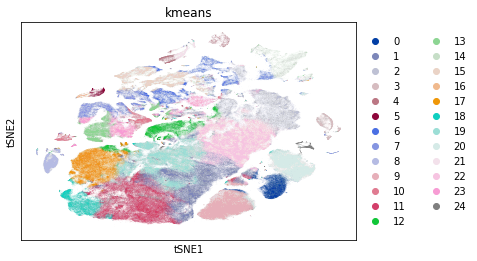

CPU times: user 5.06 s, sys: 43.2 ms, total: 5.1 s
Wall time: 5.1 s


In [39]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

We label the cells using the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively. These visualizations show us the separation of neuronal and glial cells on the t-SNE plot.

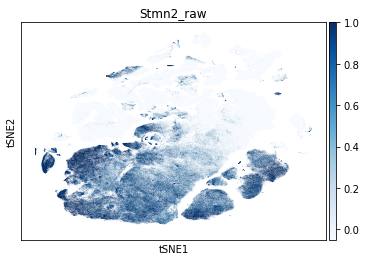

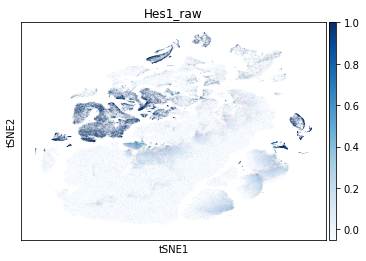

CPU times: user 5.37 s, sys: 50.8 ms, total: 5.42 s
Wall time: 5.42 s


In [40]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Louvain

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [41]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 53.3 s, sys: 7.23 s, total: 1min
Wall time: 45.1 s


The UMAP function from Rapids is also integrated into Scanpy.

In [42]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 14.6 s, sys: 6.57 s, total: 21.1 s
Wall time: 21.1 s


Finally, we use the Louvain algorithm for graph-based clustering, once again using the `rapids` option in Scanpy.

In [43]:
%%time
sc.tl.louvain(adata, resolution=louvain_resolution, flavor='rapids')

CPU times: user 1.92 s, sys: 590 ms, total: 2.51 s
Wall time: 2.5 s


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

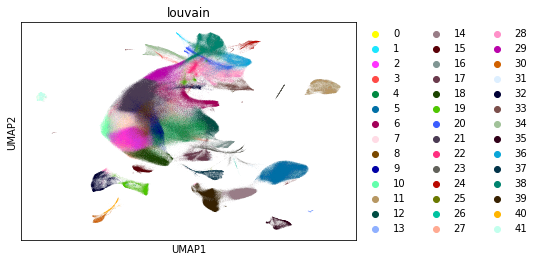

CPU times: user 4.72 s, sys: 77.4 ms, total: 4.8 s
Wall time: 4.77 s


In [44]:
%%time
sc.pl.umap(adata, color=["louvain"])

And also visualize the cells labeled by expression of the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively.

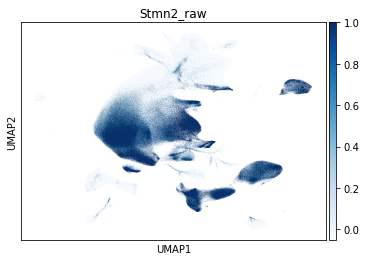

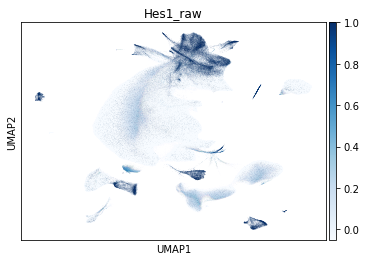

CPU times: user 5.99 s, sys: 44.5 ms, total: 6.03 s
Wall time: 6 s


In [45]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [46]:
cluster_time = time.time()
print("Total cluster time : %s" % (cluster_time-cluster_start))

Total cluster time : 170.40617609024048


## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select neurons (Stmn2+) from the dataset.

In [47]:
reanalysis_start = time.time()

In [48]:
%%time
stmn2_cells = marker_genes_raw["Stmn2_raw"] > 0.0

CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 3.22 ms


In [49]:
%%time
adata = adata[stmn2_cells.get(),:]

CPU times: user 251 ms, sys: 72.8 ms, total: 324 ms
Wall time: 323 ms


In [50]:
adata.shape

(566593, 5000)

We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds. 

Finally, we visualize the selected neuronal cells labeled by their new clusters, and by the expression of `Tbr1`, a marker gene for excitatory neurons.

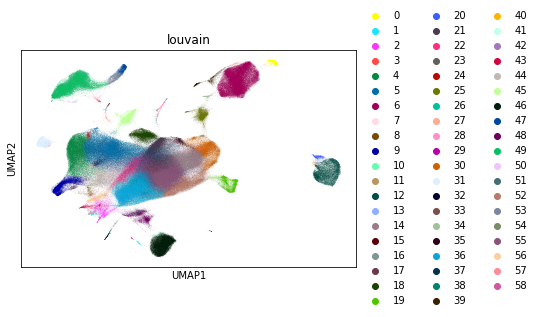

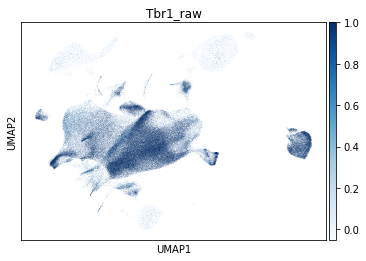

CPU times: user 1min 28s, sys: 1min 9s, total: 2min 37s
Wall time: 2min 24s


In [51]:
%%time
adata = utils.pca(adata, n_components=n_components, 
                  train_ratio=pca_train_ratio, 
                  n_batches=n_pca_batches, gpu=True)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
sc.tl.louvain(adata, flavor='rapids', resolution=louvain_resolution)

sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["Tbr1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [52]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 144.61975765228271


In [53]:
print("Full time: %s" % (time.time() - start))

Full time: 655.2663686275482
